In [1]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import json

import anndata as ad

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import mpl_fontkit as fk
fk.install("Lato")
fk.set_font("Lato")

Font name: `Lato`


In [4]:
sc.settings.figdir = './GAM-Figures/'

In [5]:
results_dir = './MT-2025-02-18/'

## Load data

In [6]:
saveprefix = 'Stromal'

In [7]:
adata = sc.read_h5ad('/nfs/team292/eg22/Datasets/Endometrium/endometriumAtlasV2_cells_with_counts.h5ad', backed='r')

In [8]:
adata.obs['Endometrial_pathology'].unique()

['C', 'E', 'E + F', 'E + A', 'E + A + F']
Categories (5, object): ['C', 'E', 'E + A', 'E + A + F', 'E + F']

In [9]:
adata.obs['Endometriosis'] = adata.obs['Endometrial_pathology'].apply(lambda x: 'Endometriosis' if x != 'C' else 'Control')
adata.obs['E_celltype'] = adata.obs['Endometriosis'].astype(str) + ' - ' + adata.obs['label_long'].astype(str)

In [10]:
with open(f'{results_dir}/cell_type_mapping.json', mode='r') as fp:
    cell_dict = json.load(fp)

In [11]:
cells = ['eStromal_MMPs', 'eStromal', 'dStromal_early', 'dStromal_mid', 'dStromal_late']

In [13]:
for i, ct in enumerate(cells):
    mt_df = pd.read_csv('{}/MT_dataframe_{}.csv'.format(results_dir, cell_dict[ct]), index_col=0)
    if i == 0:
        mt_adata = sc.AnnData(X=mt_df, obs=adata[mt_df.index].obs)
    else:
        mt_adata = ad.concat([mt_adata, sc.AnnData(X=mt_df, obs=adata[mt_df.index].obs)], join='outer')

In [14]:
mt_adata.X[np.isnan(mt_adata.X)] = 0

In [15]:
mt_adata.uns['celltype_colors'] = adata.uns['celltype_colors']

In [16]:
def filter_donors(adata, only_control = True):
    df = adata.obs
    cond_filter = (df.Stage.isin(['Proliferative', 'Proliferative Disordered', 'Proliferative Late']) & \
                   df.celltype.isin(['eStromal_MMPs', 'eStromal']) 
                  ) | \
                  (df.Stage.isin(['Secretory Early', 'Secretory Early-Mid', 'Secretory Mid', 'Secretory Late',]) & \
                   df.celltype.isin(['dStromal_early', 'dStromal_mid', 'dStromal_late']) 
                  )
    if only_control:
        cond_filter = cond_filter & (df.Endometrial_pathology == 'C')
    return adata[cond_filter]

In [17]:
adata = filter_donors(adata)
adata.shape

(58808, 17736)

In [18]:
mt_adata_og = mt_adata.copy()
mt_adata_og.shape

(132408, 215)

In [19]:
mt_adata = filter_donors(mt_adata_og)
mt_adata.shape

(58808, 215)

In [20]:
ct_dict = mt_adata.obs[['celltype', 'label_long']].reset_index(drop=True).drop_duplicates().set_index('celltype')['label_long'].to_dict()
cells = [ct_dict[c] for c in cells]

## Run GAMs to find patterns

In [21]:
gam_results = sccellfie.stats.fit_gam_model(
    mt_adata,
    cell_type_key='label_long',
    cell_type_order=cells,
    genes=None,
    n_splines=10,
    spline_order=3,
    lam=0.6,
    fit_intercept=False,
    distribution='normal',
    link='identity',
    use_pseudobulk=False,
    pseudobulk_agg='trimean',
    n_pseudobulks=10,
    cells_per_bulk=100,
)

Fitting GAMs for each var in adata: 100%|██████████| 215/215 [00:46<00:00,  4.61it/s]


In [22]:
# Analyze results
results_df = sccellfie.stats.analyze_gam_results(gam_results, fdr_level=0.01)

In [23]:
results_df.head(5)

,n_samples,edof,scale,AIC,loglikelihood,deviance,p_value,explained_deviance,mcfadden_r2,mcfadden_r2_adj,gene,significant,adj_p_value,significant_fdr
Phenylalanine to phenylacetate (via phenylacetaldehyde),58808.0,4.99927,0.393289,147849.384821,-73918.693141,58803.00073,1.110223e-16,0.502550,0.494627,0.505339,Phenylalanine to phenylacetate (via phenylacet...,True,1.147586e-16,True
Phenylalanine to phenylacetaldehyde,58808.0,4.99927,1.128089,174395.728025,-87191.864742,58803.00073,1.110223e-16,0.354885,0.858784,0.141167,Phenylalanine to phenylacetaldehyde,True,1.147586e-16,True
Degradation of uracil,58808.0,4.99927,0.124813,334471.710250,-167229.855855,58803.00073,1.110223e-16,0.238840,0.693479,0.306500,Degradation of uracil,True,1.147586e-16,True
Degradation of cytosine,58808.0,4.99927,0.124813,334471.710250,-167229.855855,58803.00073,1.110223e-16,0.238840,0.693479,0.306500,Degradation of cytosine,True,1.147586e-16,True
Conversion of glutamate to glutamine,58808.0,4.99927,0.803848,155564.910132,-77776.455796,58803.00073,1.110223e-16,0.209363,0.889261,0.110682,Conversion of glutamate to glutamine,True,1.147586e-16,True


<Axes: >

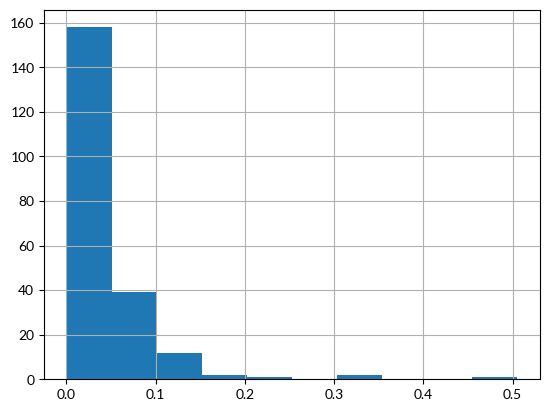

In [24]:
results_df['mcfadden_r2_adj'].hist()

<Axes: >

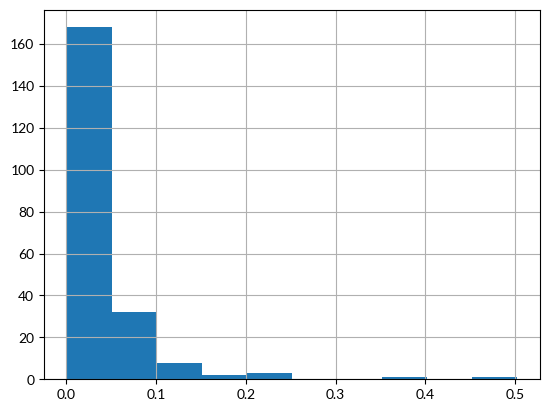

In [25]:
results_df['explained_deviance'].hist()

<Axes: >

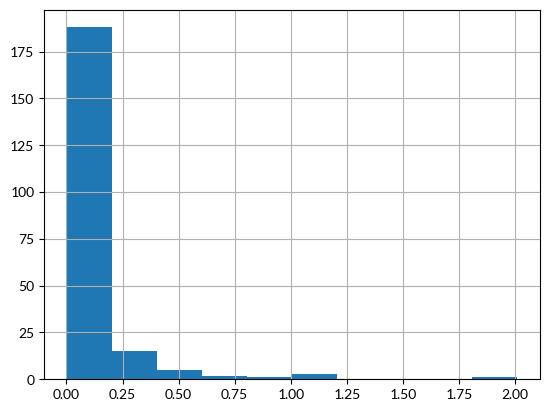

In [26]:
results_df['scale'].hist()

In [27]:
results_df.loc[(results_df['mcfadden_r2_adj'] > 0.65)]

,n_samples,edof,scale,AIC,loglikelihood,deviance,p_value,explained_deviance,mcfadden_r2,mcfadden_r2_adj,gene,significant,adj_p_value,significant_fdr


In [28]:
gam_tasks = results_df.loc[(results_df['mcfadden_r2_adj'] > 0.2) & (results_df['scale'] > 0.2)].sort_values(by='scale', ascending=False)['gene'].values.tolist()
len(gam_tasks)

1

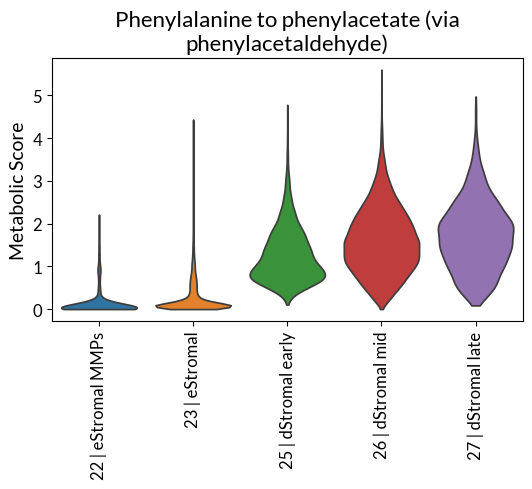

In [29]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(mt_adata,
                                                         features=gam_tasks,
                                                         groupby='label_long',
                                                         n_cols=4,
                                                         order=cells,
                                                         stripplot=False,
                                                         fontsize=12,
                                                         wrapped_title_length=45,
                                                         w_pad=None,
                                                         ylabel='Metabolic Score',
                                                         save=f'{saveprefix}-GAM-Violin-Control.pdf',
                                                         )

## Export results

In [30]:
agg_adata = filter_donors(mt_adata_og, only_control=False)

In [31]:
agg = sccellfie.expression.aggregation.agg_expression_cells(agg_adata, groupby='E_celltype', agg_func='trimean')

In [32]:
agg = agg.loc[[' - '.join([c, ct]) for ct in cells for c in ['Control', 'Endometriosis']], :]

In [33]:
agg.to_csv(f'{sc.settings.figdir}/{saveprefix}-Agg-results.csv')

In [34]:
with open(f'{sc.settings.figdir}/{saveprefix}-GAM-tasks.json', 'w') as f:
    json.dump(gam_tasks, f)

## Marsilea heatmap

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import marsilea.plotter as mp
import marsilea as ma

In [36]:
sccellfie_db = sccellfie.datasets.database.load_sccellfie_database(organism='human')

In [37]:
tasks = gam_tasks
control_cells = [c for c in agg.index if 'Control -' in c]

In [38]:
control_df = agg.loc[control_cells, tasks]
control_df.index = [idx.split(' - ')[1] for idx in control_df.index]
control_df

,Phenylalanine to phenylacetate (via phenylacetaldehyde)
22 | eStromal MMPs,0.055127
23 | eStromal,0.152614
25 | dStromal early,1.166766
26 | dStromal mid,1.553876
27 | dStromal late,1.672789


In [39]:
df_plot = sccellfie.preprocessing.min_max_normalization(control_df.T, axis=1)

In [40]:
cell_groups = {'Proliferative / Folicular' : [ct_dict[c] for c in ['eStromal_MMPs', 'eStromal']],
               'Secretory / Luteal' : [ct_dict[c] for c in ['dStromal_early', 'dStromal_mid', 'dStromal_late']]
              }

cell_groups = {cell : phase for phase, cells in cell_groups.items() for cell in cells}

In [41]:
task_dict = sccellfie_db['task_info'].set_index('Task')['System'].to_dict()
task_dict = {k : v.capitalize() for k, v in task_dict.items()}
for k, v in task_dict.items():
    if v == 'Processing in the er':
        task_dict[k] = 'Processing in the ER'
    elif v == 'Processing in the golgi':
        task_dict[k] = 'Processing in the Golgi'

In [42]:
data = df_plot.values
cell_labels = np.asarray(list(df_plot.columns))
task_labels = np.asarray(list(df_plot.index))
cell_cat = np.asarray([cell_groups[cell] for cell in df_plot.columns])
task_cat = np.asarray([task_dict[task] for task in df_plot.index])

In [43]:
total_task_cat = sorted(set(task_dict.values()))
task_palette = glasbey.extend_palette('tab10', palette_size=len(total_task_cat))
task_colors = {t : task_palette[i] for i, t in enumerate(total_task_cat)}
cell_palette = ['#D8A3B7', '#EDAF5C']

In [46]:
cell_labels = [c.split(' | ')[1] for c in cell_labels]

In [47]:
plt.rc('legend',fontsize=24, title_fontsize=28)

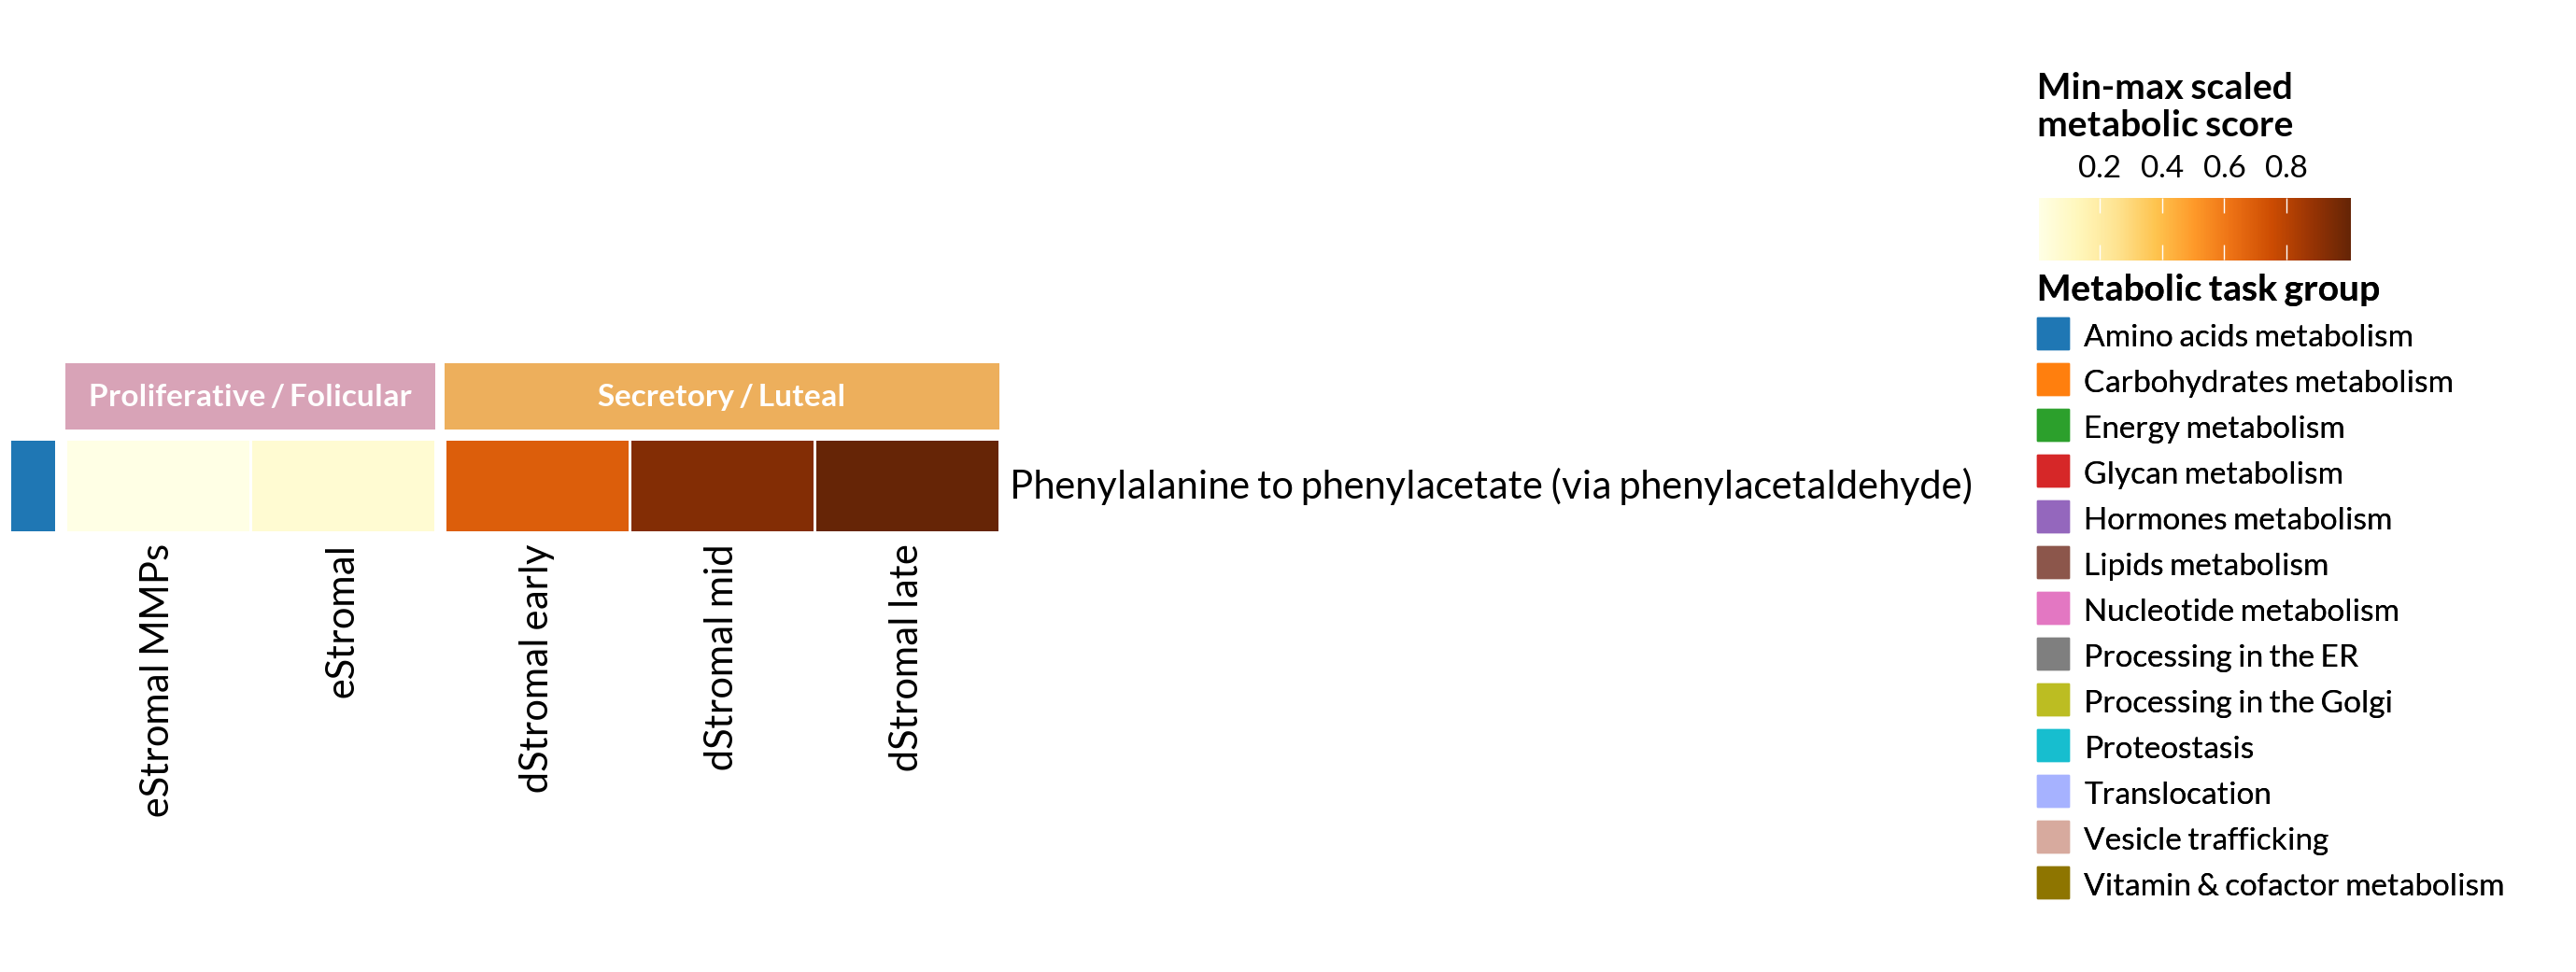

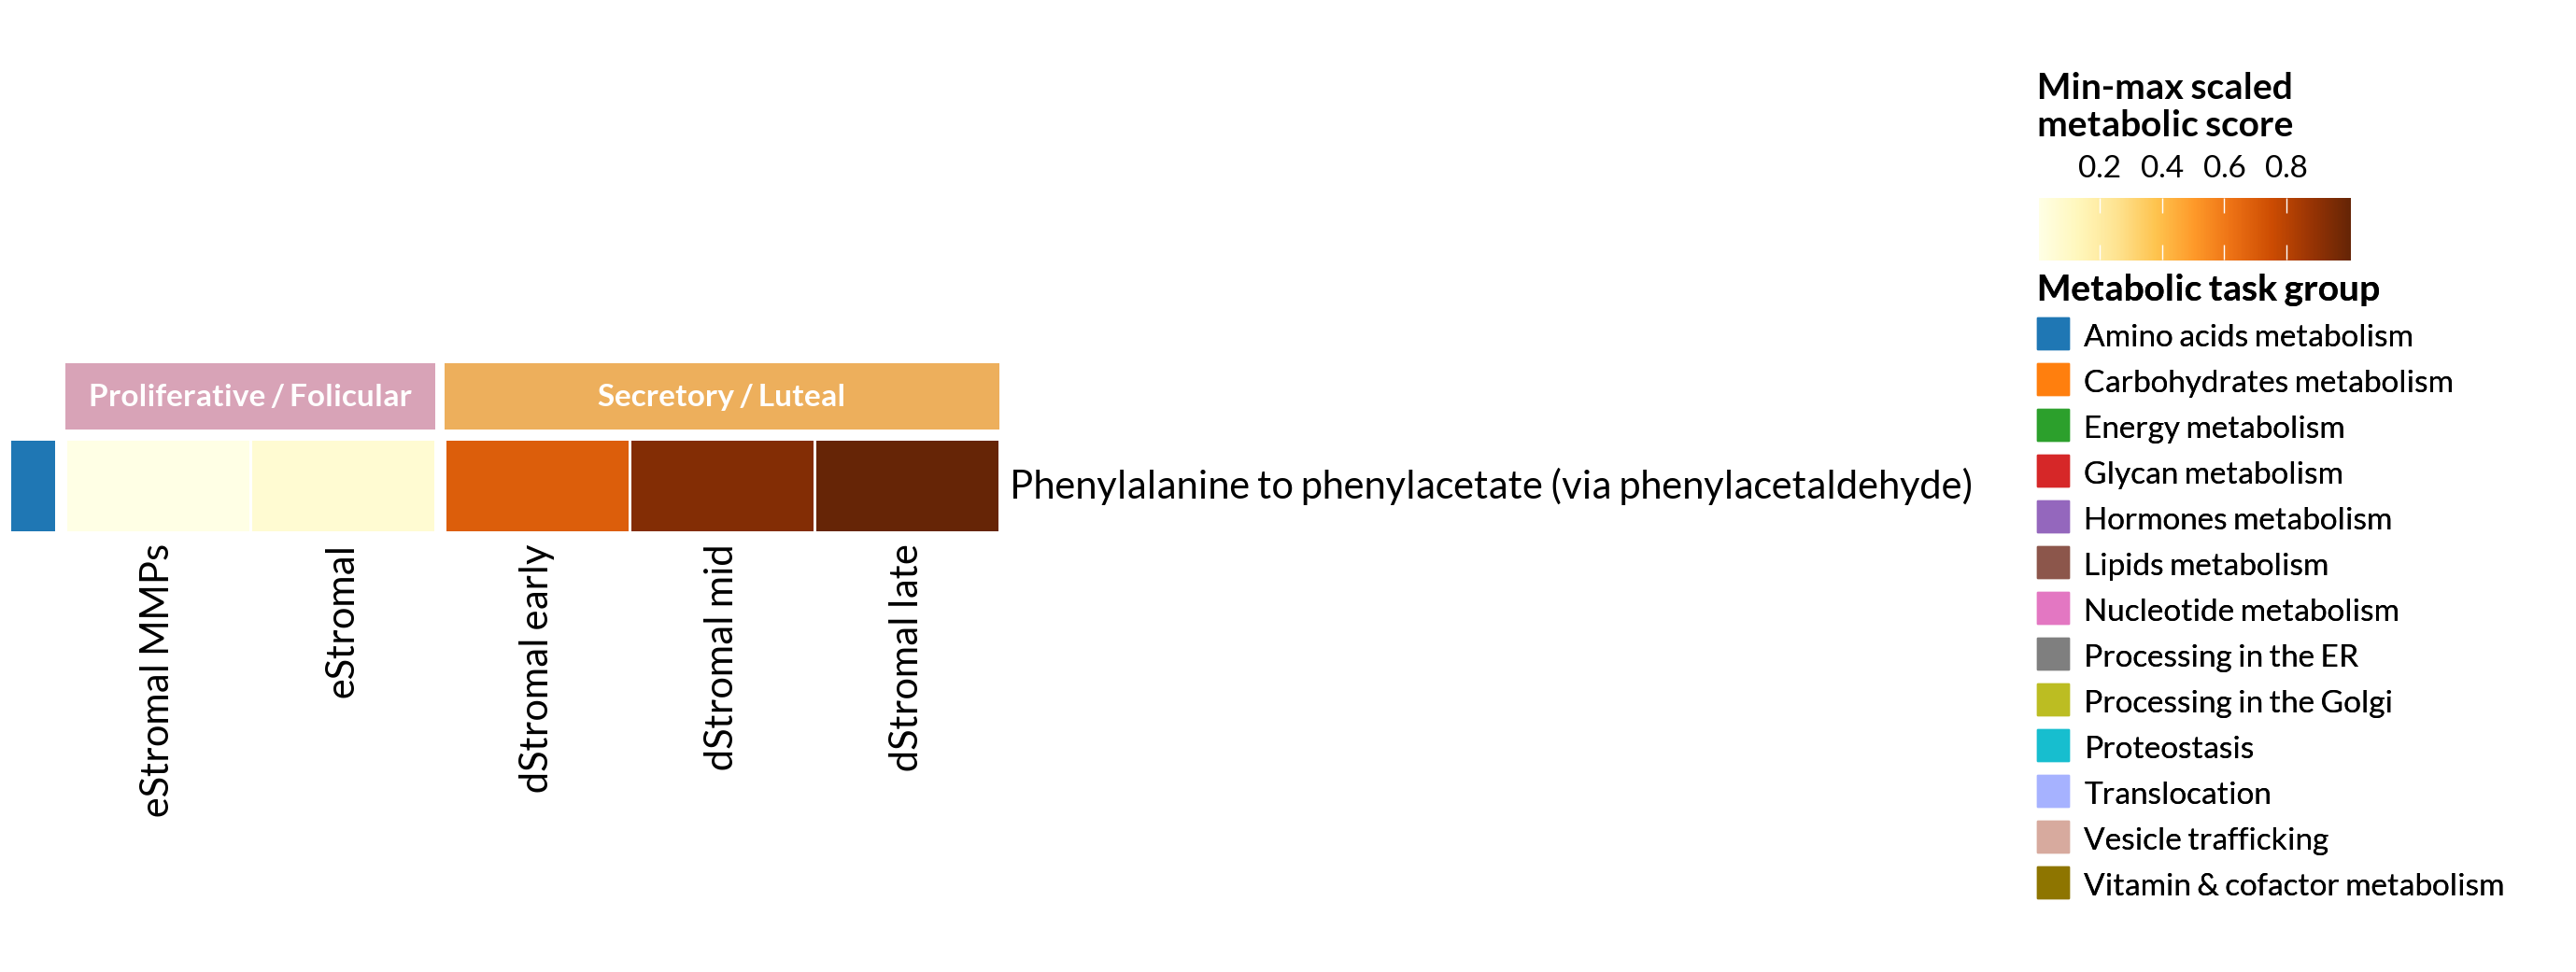

In [48]:
vlimit = np.max(np.abs(data))
linewidth = 2.
h = ma.Heatmap(data, linewidth=linewidth, vmin=0, vmax=1, height=1*len(gam_tasks), width=2.*len(cells), cmap='YlOrBr',
               cbar_kws={'title' : 'Min-max scaled\nmetabolic score', 'orientation' : 'horizontal'}, 
              )

#h.add_top(mp.Colors(cell_cat, palette=cell_palette, label='', legend_kws={'title' : 'Cell type hroup'}), size=.5, pad=.1)
h.group_cols(cell_cat, order=['Proliferative / Folicular', 'Secretory / Luteal'], spacing=0.01)
h.add_top(mp.Chunk(['Proliferative / Folicular', 'Secretory / Luteal'], cell_palette, padding=30, fontsize=24, fontweight='bold', c='white'), pad=0.1)
h.add_left(mp.Colors(task_cat, palette=task_colors, label='', legend_kws={'title' : 'Metabolic task group'}, linewidth=linewidth, linecolor='white'), size=.5, pad=.1)
h.add_bottom(mp.Labels(cell_labels, fontsize=30, rotation=90, rotation_mode='anchor', ha='right', va='center'), pad=.1)
h.add_right(mp.Labels(task_labels, fontsize=30, rotation=0, rotation_mode='anchor', ha='left', va='center'), pad=.1)
#h.vsplit(labels=cell_labels, order=sorted(set(cell_labels)), spacing=0.001)
#h.hsplit(labels=task_cat, order=sorted(set(task_cat)), spacing=0.)
#h.add_dendrogram("top", method='ward', metric='euclidean', size=1, linewidth=1., add_base=False)
#h.add_dendrogram("left", method='ward', metric='euclidean', size=1, linewidth=2., add_base=True, pad=0.05)
h.add_legends(stack_size=3, stack_by='col', align_legends='left')
h.render()
h.save(f'{sc.settings.figdir}/{saveprefix}-Heatmap.pdf', dpi=300)